In [1]:
import sqlite3
import pandas as pd

In [2]:
con = sqlite3.connect(":memory:")
cur = con.cursor()

https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

In [3]:
data = pd.read_csv('boston.csv')

In [4]:
data.to_sql("boston", con, index=False, if_exists="replace")

In [5]:
pd.read_sql(
    """
    SELECT * FROM boston
    limit 5
    """,
    con,
)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


### Все задания нужно выполнить только с помощью sql

1. Выведите количество пустых значений по колонкам CRIM, ZN, INDUS, CHAS, NOX (название колонки, кол-во пустых значений)

In [59]:
pd.read_sql(
    """
    SELECT 'CRIM' as NAME, COUNT(CRIM) as CNT
    FROM boston
    WHERE CRIM = 0 OR CRIM IS NULL
    UNION ALL
    SELECT 'ZN', COUNT(ZN)
    FROM boston
    WHERE ZN = 0 OR ZN IS NULL
    UNION ALL
    SELECT 'INDUS', COUNT(INDUS)
    FROM boston
    WHERE INDUS = 0 OR INDUS IS NULL
    UNION ALL
    SELECT 'CHAS', COUNT(CHAS)
    FROM boston
    WHERE CHAS = 0 OR CHAS IS NULL
    UNION ALL
    SELECT 'NOX', COUNT(NOX)
    FROM boston
    WHERE NOX = 0 OR NOX IS NULL
    
    """,
    con,
)

,NAME,CNT
0,CRIM,0
1,ZN,372
2,INDUS,0
3,CHAS,471
4,NOX,0


2. Выведите количество уникальных значений по колонокам CRIM, ZN, INDUS, CHAS, NOX (название колонки, кол-во уникальных значений)

In [74]:
#Решил сделать в одну строку, чтобы не писать кучу юнионов, как в примере выше.

pd.read_sql(
    """
    SELECT COUNT(DISTINCT ZN) ZN_UNIQ, COUNT (DISTINCT CRIM) CRIM_UNIQ, COUNT (DISTINCT INDUS) INDUS_UNIQ,
    COUNT (DISTINCT CHAS) CHAS_UNIQ, COUNT (DISTINCT NOX) NOX_UNIQ
    FROM boston
    """,
    con,
)

,ZN_UNIQ,CRIM_UNIQ,INDUS_UNIQ,CHAS_UNIQ,NOX_UNIQ
0,26,504,76,2,81


3. Выведите колонки, у которых медиана равна минимальному значению (название колонки) выбирая из CRIM, ZN, INDUS, CHAS, NOX.
Напишите какой вывод можно сделать по данным в этих колонках

In [114]:
pd.read_sql(
    """
    SELECT COLUMN_NAME, MEDIANA, MIN FROM(
    SELECT * FROM(
    SELECT 'ZN' AS COLUMN_NAME, ZN as MEDIANA, MIN(ZN) OVER(ORDER BY ZN) as MIN, row_number() OVER(ORDER BY ZN) as ROW
    FROM boston)
    WHERE ROW = 506 / 2
    UNION ALL
    SELECT * FROM(
    SELECT 'CRIM', CRIM, MIN(CRIM) OVER(ORDER BY CRIM), row_number() OVER(ORDER BY CRIM) as ROW
    FROM boston)
    WHERE ROW = 506 / 2
    UNION ALL
    SELECT * FROM(
    SELECT 'INDUS', INDUS, MIN(INDUS) OVER(ORDER BY INDUS), row_number() OVER(ORDER BY INDUS) AS ROW
    FROM boston)
    WHERE ROW = 506 / 2
    UNION ALL
    SELECT * FROM(
    SELECT 'CHAS', CHAS, MIN(CHAS) OVER(ORDER BY CHAS), row_number() OVER(ORDER BY CHAS) AS ROW
    FROM boston)
    WHERE ROW = 506 / 2
    UNION ALL
    SELECT * FROM(
    SELECT 'NOX', NOX, MIN(NOX) OVER(ORDER BY NOX), row_number() OVER(ORDER BY NOX) AS ROW
    FROM boston)
    WHERE ROW = 506 / 2
    )
    WHERE MEDIANA = MIN
    """,
    con,
)
# Более половины значений в этих колонках - нулевые.
# Более половины участков не граничат с рекой
# Более половины участков менее 25000 кв. футов.

,COLUMN_NAME,MEDIANA,MIN
0,ZN,0.0,0.0
1,CHAS,0.0,0.0


4. Выведите разницу между среднем количеством комнат(RM) в домах с самой дорогой стоимостью(MEDV) и 25 самыми дешевыми домами. 
Аналогично по 50, 100, 200, 300 самыми дешевыми домами. (кол-во домов(25,50,100,200,300), среднее кол-во комнат в них, среднее кол-во комнат в самых дорогих, разница).
Напишите влияет ли кол-во комнат на стоимость и как сильно.

In [177]:
pd.read_sql(
    """
    SELECT 25 as "Количество домов", AVG(ARM) as 'Среднее кол-во комнат',
    
    (SELECT AVG(RM) OVER(partition by MEDV order by MEDV) as AVGRM_MAXPRICE
    FROM boston
    ORDER BY MEDV DESC
    LIMIT 1) as 'Среднее кол-во комнат в самых дорогих',
    
    AVG(ARM-(
    SELECT AVG(RM) OVER(partition by MEDV order by MEDV) as AVGRM_MAXPRICE
    FROM boston
    ORDER BY MEDV DESC
    LIMIT 1)) as Разница
    FROM (SELECT RM as ARM FROM boston ORDER BY MEDV LIMIT 25)
    
    UNION ALL
    
    SELECT 50 as "Количество домов", AVG(ARM) as 'Среднее кол-во комнат',
    
    (SELECT AVG(RM) OVER(partition by MEDV order by MEDV) as AVGRM_MAXPRICE
    FROM boston
    ORDER BY MEDV DESC
    LIMIT 1) as 'Среднее кол-во комнат в самых дорогих',
    
    AVG(ARM-(
    SELECT AVG(RM) OVER(partition by MEDV order by MEDV) as AVGRM_MAXPRICE
    FROM boston
    ORDER BY MEDV DESC
    LIMIT 1)) as Разница
    FROM (SELECT RM as ARM FROM boston ORDER BY MEDV LIMIT 50)
    
    UNION ALL
    SELECT 100 as "Количество домов", AVG(ARM) as 'Среднее кол-во комнат',
    
    (SELECT AVG(RM) OVER(partition by MEDV order by MEDV) as AVGRM_MAXPRICE
    FROM boston
    ORDER BY MEDV DESC
    LIMIT 1) as 'Среднее кол-во комнат в самых дорогих',
    
    AVG(ARM-(
    SELECT AVG(RM) OVER(partition by MEDV order by MEDV) as AVGRM_MAXPRICE
    FROM boston
    ORDER BY MEDV DESC
    LIMIT 1)) as Разница
    FROM (SELECT RM as ARM FROM boston ORDER BY MEDV LIMIT 100)
    
    UNION ALL
    SELECT 200 as "Количество домов", AVG(ARM) as 'Среднее кол-во комнат',
    
    (SELECT AVG(RM) OVER(partition by MEDV order by MEDV) as AVGRM_MAXPRICE
    FROM boston
    ORDER BY MEDV DESC
    LIMIT 1) as 'Среднее кол-во комнат в самых дорогих',
    
    AVG(ARM-(
    SELECT AVG(RM) OVER(partition by MEDV order by MEDV) as AVGRM_MAXPRICE
    FROM boston
    ORDER BY MEDV DESC
    LIMIT 1)) as Разница
    FROM (SELECT RM as ARM FROM boston ORDER BY MEDV LIMIT 200)
    
    UNION ALL
    SELECT 300 as "Количество домов", AVG(ARM) as 'Среднее кол-во комнат',
    
    (SELECT AVG(RM) OVER(partition by MEDV order by MEDV) as AVGRM_MAXPRICE
    FROM boston
    ORDER BY MEDV DESC
    LIMIT 1) as 'Среднее кол-во комнат в самых дорогих',
    
    AVG(ARM-(
    SELECT AVG(RM) OVER(partition by MEDV order by MEDV) as AVGRM_MAXPRICE
    FROM boston
    ORDER BY MEDV DESC
    LIMIT 1)) as Разница
    FROM (SELECT RM as ARM FROM boston ORDER BY MEDV LIMIT 300)

    """,
    con,
)

# Количество комнат влияет на стоимость жилья, при этом достаточно сильно. Чем больше комнат, тем дороже недвижимость. 
# Для исследования абсолютных показателей лучше использовать уже python. Либо писать запросы со скользящим окном.

,Количество домов,Среднее кол-во комнат,Среднее кол-во комнат в самых дорогих,Разница
0,25,5.747840,7.484,-1.736160
1,50,5.753240,7.484,-1.730760
2,100,5.887120,7.484,-1.596880
3,200,5.911705,7.484,-1.572295
4,300,5.972227,7.484,-1.511773


5. Выведите ранги значений колонки LSTAT(процент населения с более низким статусом) в домах с самой дорогой стоимостью (значение LSTAT, стоимость, ранг) среди всех знаечений LSTAT. Напишите какой вывод можно сделать по этим данным.

In [186]:
pd.read_sql(
    """
    SELECT LSTAT, MEDV, Rank_LSTAT FROM(
    SELECT rank() OVER(ORDER BY LSTAT) as Rank_LSTAT, *
    FROM boston)
    WHERE MEDV = (SELECT MAX(MEDV) FROM boston)
    """,
    con,
)

# На участках с самой дорогой недвижимостью процент населения с более низким статусом достаточно низкий. Максимальный - 9,53%.

,LSTAT,MEDV,Rank_LSTAT
0,1.73,50.0,1
1,1.92,50.0,2
2,2.88,50.0,6
3,2.96,50.0,8
4,2.97,50.0,9
5,3.16,50.0,15
6,3.26,50.0,17
7,3.32,50.0,18
8,3.70,50.0,26
9,3.73,50.0,27


6. Выведите среднюю стоимость домов граничащих с рекой(CHAS) и нет (граничит/не граничит, стоимость)

In [193]:
pd.read_sql(
    """
    SELECT AVG(MEDV) as 'Средняя стоимость домов', 'Граничит' as "Граничит ли с рекой"
    FROM boston
    WHERE CHAS = 1
    
    UNION ALL
    SELECT AVG(MEDV), 'Не граничит'
    FROM boston
    WHERE CHAS = 0
    """,
    con,
)

,Средняя стоимость домов,Граничит ли с рекой
0,28.440000,Граничит
1,22.093843,Не граничит


7. Выведите все колонки, у которых среднее значение выше, когда дом граничит с рекой (название колонки) выбирая из CRIM, ZN, INDUS, CHAS, NOX. Напишите какой вывод можно сделать по этим данным.

In [213]:
pd.read_sql(
    """
    SELECT * FROM(
    SELECT 'CRIM' as 'Колонка', (SELECT AVG(CRIM) FROM boston WHERE CHAS = 0) as 'CHAS0', 
    (SELECT AVG(CRIM) FROM boston WHERE CHAS = 1) as 'CHAS1'
    UNION ALL
    SELECT 'ZN' as 'Колонка', (SELECT AVG(ZN) FROM boston WHERE CHAS = 0) as 'CHAS0', 
    (SELECT AVG(ZN) FROM boston WHERE CHAS = 1) as 'CHAS1'
    UNION ALL
    SELECT 'INDUS' as 'Колонка', (SELECT AVG(INDUS) FROM boston WHERE CHAS = 0) as 'CHAS0', 
    (SELECT AVG(INDUS) FROM boston WHERE CHAS = 1) as 'CHAS1'
    UNION ALL
    SELECT 'NOX' as 'Колонка', (SELECT AVG(NOX) FROM boston WHERE CHAS = 0) as 'CHAS0', 
    (SELECT AVG(NOX) FROM boston WHERE CHAS = 1) as 'CHAS1'
    )
    WHERE CHAS0 < CHAS1
    """,
    con,
)

# На участках у реки выше показатель доли акров неторгового бизнеса и концентрации оксидов азота. 
# Вероятно, связано с наличием производственных предприятий, которые осуществляют забор воды из реки.

,Колонка,CHAS0,CHAS1
0,INDUS,11.019193,12.719143
1,NOX,0.551817,0.593426


8. Выведите значения долей промышленной застройки(INDUS), концентрации оксидов азота(NOX) и по их перцентилям - 10, 20 ... 100 ( перцетиль(10,20...100),значение INDUS, значение NOX). Напишите прослеживается между ними взаимосвязь

In [244]:
df = pd.read_sql(
    """
    SELECT INDUS, NOX, round(rank_nox/5.06) as Перцентиль_NOX, round(rank_indus/5.06) as Перцентиль_INDUS  
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_nox = round(506 * 0.1) --or rank_indus = round(506 * 0.1)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_nox = round(506 * 0.2) --or rank_indus = round(506 * 0.2)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_nox = round(506 * 0.3) --or rank_indus = round(506 * 0.3)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_nox = round(506 * 0.4) --or rank_indus = round(506 * 0.4)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_nox = round(506 * 0.5) --or rank_indus = round(506 * 0.5)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_nox = round(506 * 0.6) --or rank_indus = round(506 * 0.6)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_nox = round(506 * 0.7) --or rank_indus = round(506 * 0.7)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_nox = round(506 * 0.8) --or rank_indus = round(506 * 0.8)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_nox = round(506 * 0.9) --or rank_indus = round(506 * 0.9)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_nox = round(506) --or rank_indus = round(506)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_indus = round(506 * 0.1)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_indus = round(506 * 0.2)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_indus = round(506 * 0.3)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_indus = round(506 * 0.4)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_indus = round(506 * 0.5)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_indus = round(506 * 0.6)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_indus = round(506 * 0.7)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_indus = round(506 * 0.8)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_indus = round(506 * 0.9)
    
    UNION ALL
    SELECT INDUS, NOX, round(rank_nox/5.06), round(rank_indus/5.06)
    FROM (
    SELECT INDUS, NOX, NTILE(506) over(ORDER BY NOX) AS rank_nox, NTILE(506) over(ORDER BY INDUS) AS rank_indus FROM boston
    )
    WHERE rank_indus = round(506)
    """,
    con,
)

df
# В целом, прослеживается тенденция к увеличению NOX при повышении INDUS. Видимо, производства влияют на концентрацию оксидов Азота.

,INDUS,NOX,Перцентиль_NOX,Перцентиль_INDUS
0,4.86,0.426,10.0,22.0
1,4.39,0.442,20.0,20.0
2,2.18,0.472,30.0,6.0
3,6.20,0.507,40.0,33.0
4,8.14,0.538,50.0,43.0
5,3.97,0.575,60.0,18.0
6,19.58,0.605,70.0,94.0
7,18.10,0.668,80.0,66.0
8,18.10,0.713,90.0,82.0
9,19.58,0.871,100.0,92.0


In [242]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='INDUS', ylabel='NOX'>

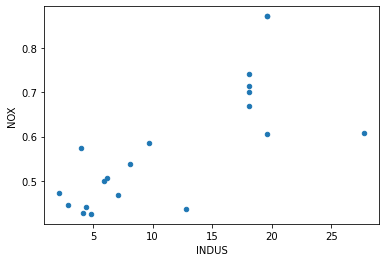

In [250]:
df.plot.scatter(x='INDUS', y='NOX') #Для подтверждения зависимости.